In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from sklearn import preprocessing

In [ ]:
import keras
import keras.backend as K
from keras.layers import Activation
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM

In [ ]:
model_path = '/content/regression_model.h5'

In [ ]:
train = pd.read_csv('/content/PM_train.txt', sep=" ", header=None)
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
train.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
train = train.sort_values(['id','cycle'])

In [ ]:
test = pd.read_csv('/content/PM_test.txt', sep=" ", header=None)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
test.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
truth = pd.read_csv('/content/PM_truth.txt', sep=" ", header=None)
truth.drop(truth.columns[[1]], axis=1, inplace=True)

In [ ]:
rul = pd.DataFrame(train.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train = train.merge(rul, on=['id'], how='left')
train['RUL'] = train['max'] - train['cycle']
train.drop('max', axis=1, inplace=True)

In [ ]:
w1 = 30
w0 = 15
train['label1'] = np.where(train['RUL'] <= w1, 1, 0 )
train['label2'] = train['label1']
train.loc[train['RUL'] <= w0, 'label2'] = 2

In [ ]:
train['cycle_norm'] = train['cycle']

In [ ]:
cols_normalize = train.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]), columns=cols_normalize, index=train.index)
join_df = train[train.columns.difference(cols_normalize)].join(norm_train)
train = join_df.reindex(columns = train.columns)

In [ ]:
test['cycle_norm'] = test['cycle']

In [ ]:
norm_test = pd.DataFrame(min_max_scaler.transform(test[cols_normalize]), columns=cols_normalize, index=test.index)
test_join = test[test.columns.difference(cols_normalize)].join(norm_test)
test = test_join.reindex(columns = test.columns)
test = test.reset_index(drop=True)
print(test.head())

   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s13       s14       s15  s16       s17  s18  s19       s20  \
0  0.0  ...  0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0  0.558140   
1  0.0  ...  0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0  0.682171   
2  0.0  ...  0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0  0.728682   
3  0.0  ...  0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0  0.666667   
4  0.0  ...  0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0  0.658915   

        s21  cycle_norm  
0  0.6

In [ ]:
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth.columns = ['more']
truth['id'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth.drop('more', axis=1, inplace=True)

In [ ]:
test = test.merge(truth, on=['id'], how='left')
test['RUL'] = test['max'] - test['cycle']
test.drop('max', axis=1, inplace=True)

In [ ]:
test['label1'] = np.where(test['RUL'] <= w1, 1, 0 )
test['label2'] = test['label1']
test.loc[test['RUL'] <= w0, 'label2'] = 2

In [ ]:
sequence_length = 50

In [ ]:
def gen_sequence(id, seq_length, seq_cols):
  data_matrix = id[seq_cols].values
  num_elements = data_matrix.shape[0]
  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    yield data_matrix[start:stop, :]

In [ ]:
sensor_cols= ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [ ]:
val=list(gen_sequence(train[train['id']==1], sequence_length, sequence_cols))
print(len(val))

142


In [ ]:
seq_gen = (list(gen_sequence(train[train['id']==id], sequence_length, sequence_cols))
for id in train['id'].unique())

In [ ]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [ ]:
def gen_labels(id, seq_length, label):
  data_matrix = id[label].values
  num_elements = data_matrix.shape[0]
  return data_matrix[seq_length:num_elements, :]

In [ ]:
label_gen = [gen_labels(train[train['id']==id], sequence_length, ['RUL'])
for id in train['id'].unique()]

In [ ]:
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [ ]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [ ]:
model=Sequential()

In [ ]:
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', r2_keras])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 

In [ ]:
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'), keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
75/75 [==============================] - 40s 428ms/step - loss: 8817.3701 - mae: 75.1986 - r2_keras: -1.7159 - val_loss: 8231.5098 - val_mae: 72.2995 - val_r2_keras: -2.4622
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 17s 230ms/step - loss: 8137.4072 - mae: 71.2447 - r2_keras: -1.5092 - val_loss: 7703.0698 - val_mae: 69.2296 - val_r2_keras: -2.2126
Epoch 3/100
75/75 [==============================] - 17s 228ms/step - loss: 7628.6655 - mae: 68.3212 - r2_keras: -1.3491 - val_loss: 7207.3774 - val_mae: 66.3663 - val_r2_keras: -1.9803
Epoch 4/100
75/75 [==============================] - 17s 225ms/step - loss: 7138.8706 - mae: 65.5538 - r2_keras: -1.1986 - val_loss: 6741.5786 - val_mae: 63.6928 - val_r2_keras: -1.7640
Epoch 5/100
75/75 [==============================] - 17s 233ms/step - loss: 6685.2256 - mae: 62.9523 - r2_keras: -1.0563 - val_loss: 6303.2793 - val_mae: 61.1952 - val_r2_keras: -1.5626
Epoch 6/100
75/75 [==============================] - 17s 222ms/step - loss: 6257.5176 - mae: 60.5505 - r2_keras: -0.9316 - val_loss: 5892.7197 - val_mae: 58.8775 - val_r2_keras: -1.3762
Epoch 7/100
75/75 [==============================] - 19s 250ms/step - loss: 5865.3

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])

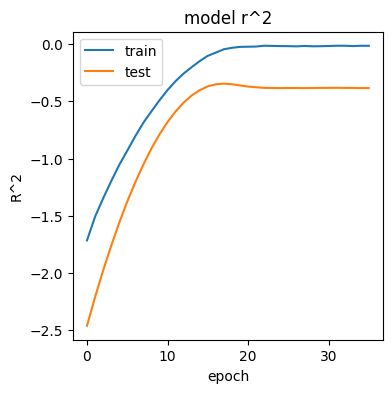

In [ ]:
fig_acc = plt.figure(figsize=(4, 4))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

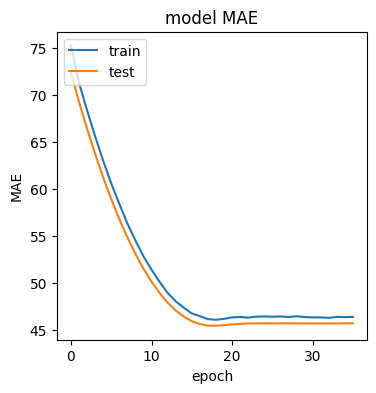

In [ ]:
fig_acc = plt.figure(figsize=(4, 4))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

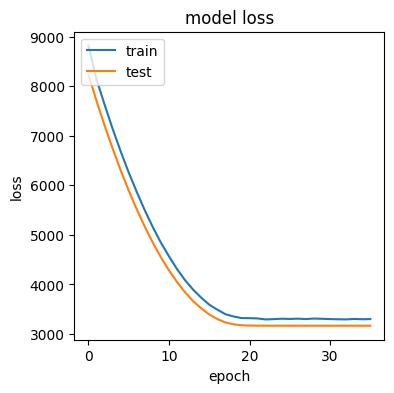

In [ ]:
fig_acc = plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

79/79 [==============================] - 7s 82ms/step - loss: 3265.3259 - mae: 46.1428 - r2_keras: -1.0200

MAE: 46.14284133911133

R^2: -1.0200226306915283


In [ ]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

79/79 [==============================] - 7s 82ms/step


In [ ]:
test_set = pd.DataFrame(y_pred)
test_set.to_csv('/content/submit_train.csv', index = None)

In [ ]:
seq_array_test_last = [test[test['id']==id][sequence_cols].values[-sequence_length:]
for id in test['id'].unique() if len(test[test['id']==id]) >= sequence_length]

In [ ]:
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

In [ ]:
print("seq_array_test_last")

seq_array_test_last


In [ ]:
seq_array_test_last.shape

(93, 50, 25)

In [ ]:
y_mask = [len(test[test['id']==id]) >= sequence_length for id in test['id'].unique()]
label_array_test_last = test.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

(93, 1)
label_array_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [111.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 83.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [119.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [106.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [109.]
 [114.]
 [ 47.]
 [135.]
 [ 92.]
 [ 21.]
 [ 79.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [128.]
 [ 14.]
 [ 77.]
 [  8.]
 [121.]
 [ 94.]
 [118.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [107.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [137.]
 [ 58.]
 [ 89.]
 [116.]
 [115.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


3/3 - 1s - loss: 1821.9705 - mae: 35.9903 - r2_keras: -9.7619e-02 - 878ms/epoch - 293ms/step

MAE: 35.990333557128906

R^2: -0.09761929512023926
3/3 [==============================] - 1s 17ms/step


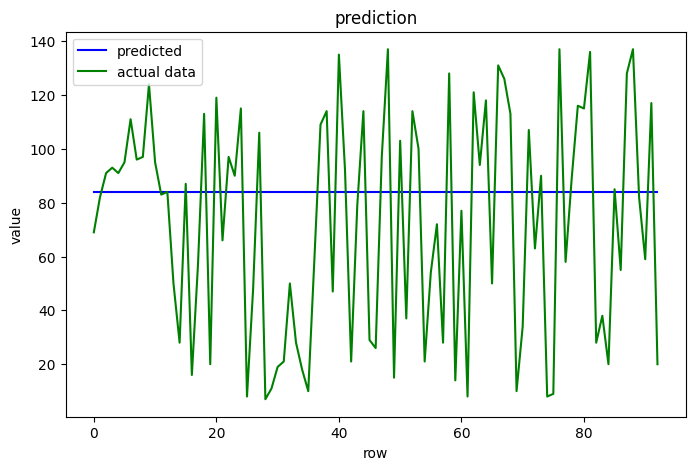

In [ ]:
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('/content/submit_test.csv', index = None)
    fig_verify = plt.figure(figsize=(8, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()